# 1.2 数据集与训练

为了能用深度学习来解决现实世界的问题，我们经常从预处理原始数据开始， 而不是从那些准备好的张量格式数据开始。在Python中常用的数据分析工具中，我们通常使用pandas软件包。 像庞大的Python生态系统中的许多其他扩展包一样，pandas可以与张量兼容。

这里，将简要介绍使用pandas预处理原始数据，并将原始数据转换为张量格式。当然数据处理的方法还有很多，可以自行找相关资料，版块也会在后面对相关内容进行扩展。

## 1.2.1 数据预处理

我们首先创建一个数据集csv文件，存放在[本地文件夹](../../data/house_price.csv)，以其他格式存储的数据也可以通过类似的方式进行处理。 下面我们将数据集按行写入CSV文件中。

In [46]:
import os

os.makedirs(os.path.join('../..', 'data'), exist_ok=True)
data_file = os.path.join('../..', 'data', 'house_price.csv')
# 重写这个文件（会覆盖掉开始的结果）
with open(data_file, 'w') as f:
    f.write('NumRooms,Alley,Price\n')  # 列名
    f.write('NA,Pave,127500\n')  # 每行表示一个数据样本
    f.write('2,NA,106000\n')
    f.write('4,NA,178100\n')
    f.write('NA,NA,140000\n')

下面使用**pandas**进行相关数据处理

In [47]:
# 下面一行代码可以帮助你的机器安装pandas
# !pip install pandas

import pandas as pd
import numpy as np

data = pd.read_csv(data_file)
data

,NumRooms,Alley,Price
0,NaN,Pave,127500
1,2.0,NaN,106000
2,4.0,NaN,178100
3,NaN,NaN,140000


1. 处理缺失值

In [48]:
inputs, outputs = data.iloc[:, 0:2], data.iloc[:, 2]
inputs = inputs.fillna(inputs.mean())
inputs

,NumRooms,Alley
0,3.0,Pave
1,2.0,NaN
2,4.0,NaN
3,3.0,NaN


下面将NaN视为一个类别。 由于巷子类型（Alley）列只接受两种类型的类别值Pave和NaN， pandas可以自动将此列转换为两列Alley_Pave和Alley_nan。 巷子类型为Pave的行会将Alley_Pave的值设置为1，Alley_nan的值设置为0。 缺少巷子类型的行会将Alley_Pave和Alley_nan分别设置为0和1。

In [49]:
inputs_fillna = pd.get_dummies(inputs, dummy_na=True)
print(inputs_fillna)

   NumRooms  Alley_Pave  Alley_nan
0       3.0           1          0
1       2.0           0          1
2       4.0           0          1
3       3.0           0          1


2. 删除和插值

In [50]:
# 删除有空的那一整行
drops = inputs.isnull().any(axis=1)
inputs_dropna = inputs[~drops]
inputs_dropna

,NumRooms,Alley
0,3.0,Pave


``interpolate``为插值函数,其相关参数可以查阅[pandas官方文档](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.interpolate.html)

In [51]:
# 插值
inputs_interpolate = inputs.interpolate(limit_direction='both')
inputs_interpolate  # 如果是str类型的仍然是无法填充的

,NumRooms,Alley
0,3.0,Pave
1,2.0,NaN
2,4.0,NaN
3,3.0,NaN


3. 转换为张量形式，传入pandas的values属性即可转换未完成

In [52]:
import torch

X, y = torch.tensor(inputs_fillna.values), torch.tensor(outputs.values)
X, y

(tensor([[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]], dtype=torch.float64),
 tensor([127500, 106000, 178100, 140000]))

## 1.2.2 数据集构建
为了后续使用pytorch求梯度更加方便

In [53]:
from torch.utils.data import Dataset, DataLoader

# 继承Dataset类
class MyDataset(Dataset):
    def __init__(self, data):
        """读取数据和其他预处理操作"""
        self.data = data

    def __getitem__(self, index):
        """每次获取一个样本"""
        return self.data[index]

    def __len__(self):
        """返回数据集的size"""
        return len(self.data)


In [54]:
dataset = MyDataset((X, y))
# shuffle在训练期间一般为True，测试时候为false
dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # shuffle参数为True代表先扰乱数据集顺序
# 转成python的iter
next(iter(dataloader))

tensor([[[3., 1., 0.],
         [2., 0., 1.],
         [4., 0., 1.],
         [3., 0., 1.]]], dtype=torch.float64)

1. 模型定义

In [55]:
# 模型定义
from torch import nn

# 单层线性神经网络
net_single = nn.Sequential(nn.Linear(2, 1))  # input数位2，output数位1

# 定义多层感知机
net_multi = nn.Sequential(nn.Flatten(), nn.Linear(784, 256), nn.ReLU(), nn.Linear(256, 10))  # Relu为激活函数，接下来会讲解到

2. 激活函数,常见的有:
* Relu
* sigmoid
* tanh
* softplus
下面对四种激活函数画出其图像。

In [56]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

# 给定数据
x = torch.linspace(-3, 3, 100)
x_np = x.data.numpy()

In [57]:
y_relu = torch.relu(x).data.numpy()
y_sigmoid = torch.sigmoid(x).data.numpy()
y_tanh = torch.tanh(x).data.numpy()
y_softplus = F.softplus(x).data.numpy()

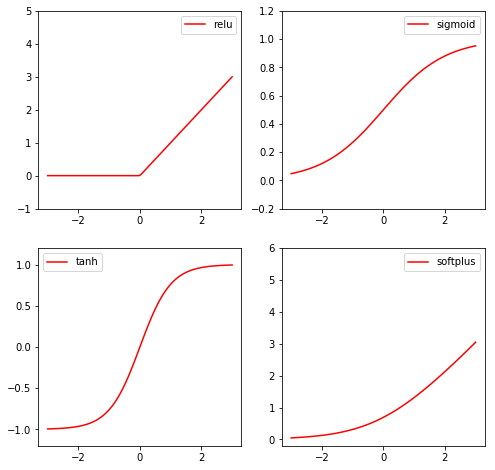

In [58]:
plt.figure(1, figsize=(8, 8))

plt.subplot(221)
plt.plot(x_np, y_relu, c='red', label='relu')
plt.ylim(-1, 5)
plt.legend(loc='best')

plt.subplot(222)
plt.plot(x_np, y_sigmoid, c='red', label='sigmoid')
plt.ylim(-0.2, 1.2)
plt.legend(loc='best')

plt.subplot(223)
plt.plot(x_np, y_tanh, c='red', label='tanh')
plt.ylim(-1.2, 1.2)
plt.legend(loc='best')

plt.subplot(224)
plt.plot(x_np, y_softplus, c='red', label='softplus')
plt.ylim(-0.2, 6)
plt.legend(loc='best')
plt.show()

3. 损失函数，更多损失函数使用可以查阅[pytorch的官方文档](https://pytorch.org/docs/stable/nn.html#loss-functions)

* rmse:
$rmse = \sqrt{\frac{1}{m} \sum_{i=1}^{m}\left(y_{i}-y_{i}\right)^{2}}$

* crossentropy:
$H(p, q)=-\sum_{x}(p(x) \log q(x)$

In [59]:
rmse = nn.MSELoss()
ce = nn.CrossEntropyLoss()

4. 自定义神经网络

In [60]:
import torch.nn as nn

class MyModel(nn.Module):
    def __init__(self):
        """初始化你的模型，并且定义你的层"""
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(10, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1),

        )

    def forward(self, X):
        """前向传播计算你的神经网络"""
        return X - X.sum()


device = torch.device("cpu")  # 默认使用cpu
if torch.cuda.is_available():  # 查看是否有cuda的设备
    device = torch.device("cuda")          # GPU


model = MyModel().to(device=device)
model(torch.ones(2, 10))
print('parameters is on:', model.net[0].weight.data.device)

parameters is on: cpu


* 模型参数保存和加载

In [61]:
path = '../../data/model_pa'
# 保存
torch.save(model.state_dict(), path)

In [62]:
# 加载
loading = torch.load(path)
model.load_state_dict(loading)

<All keys matched successfully>

* 无参数的自定义层

In [63]:
# 无参数自定义层
class CenteredLayer(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, X):
        return X - X.sum()

layer = CenteredLayer()
layer(torch.FloatTensor([1, 2, 3, 4, 5]))

tensor([-14., -13., -12., -11., -10.])

In [64]:
# 合并到更加复杂网络当中
net = nn.Sequential(nn.Linear(8, 128), CenteredLayer())

Y = net(torch.rand(4, 8))
Y.shape

torch.Size([4, 128])

* 带参数自定义层

In [65]:
# 带参数自定义层
class MyLinear(nn.Module):
    def __init__(self, in_units, units):
        super().__init__()
        self.weight = nn.Parameter(torch.randn(in_units, units))
        self.bias = nn.Parameter(torch.randn(units,))

    def forward(self, X):
        linear = torch.matmul(X, self.weight.data) + self.bias.data
        return F.relu(linear)

dense = MyLinear(5, 3)
print(f'dense weight:', dense.weight)

dense weight: Parameter containing:
tensor([[-1.7601,  0.4194, -0.1516],
        [ 1.1785, -1.5666, -0.0681],
        [-2.0428,  0.1049, -0.2552],
        [-0.4981, -1.0176,  1.7484],
        [-0.4637,  0.8961,  0.2325]], requires_grad=True)


In [66]:
net = nn.Sequential(MyLinear(64, 8), MyLinear(8, 1))
Y = net(torch.rand(2, 64))
Y.shape

torch.Size([2, 1])

5. 优化算法
* 随机梯度下降(SGD)
* 其他优化算法可以参考[pytorch官方文档](https://pytorch.org/docs/stable/optim.html)

In [67]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0)
optimizer  # 查看一下优化器的属性

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.1
    momentum: 0
    nesterov: False
    weight_decay: 0
)

### 模型训练
下面代码展示的只是**主要过程**，不是可执行代码

1. 训练集(Training Set)
```python
for epoch in range(n_epochs):  # 迭代的epoch
    model.train()  # 设置为训练状态
    for x, y in tr_set:  # tr_set为训练集的dataloader
        optimizer.zero_grad()  # 每次迭代都要讲梯度清零
        x, y = x.to(device), y.to(device)  # 移动数据到你所要使用的设备
        pred = model(x)  # 正向传播计算输出
        loss = criterion(pred, y)  # 计算损失函数值
        loss.backward()  # 反向传播计算梯度
        optimizer.step()  # 更新模型的优化器
```

2. 验证集(Validation Set)
```python
model.eval()  # 设置模型为评估模式
total_loss = 0
for x, y in dv_set:  # 验证集的迭代器
    x, y = x.to(device), y.to(device)
    with torch.no_grad():  # 不要计算梯度，加快执行时间
        pred = model(x)
        loss = criterion(pred, y)
        total_loss += loss.cpu().item() * len(x)  # 计算累计的损失
        avg_loss = total_loss / len(dv_set.dataset)  # 计算平均误差
```

3. 测试集(Testing Set)
```python
model.eval()
preds = []
for x in tt_set:
    x = x.to(device)
    with torch.no_grad():
        pred = model(x)
        preds.append(pred.cpu())
```